In [1]:
import os
import glob
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torchvision import transforms

from torch.nn.modules.activation import ReLU, Sigmoid
from torch.nn import Conv2d, modules
from torch.nn import Sequential

In [2]:
# utils functions
def img_read(fPath):
    '''
    read the image given path "fPath"
    '''
    img = cv2.imread(fPath, -1) # single channel image
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def getLR(hr_img, scale, resize=True):
    '''
    bibubic downsmaple to get the corresponding low-resolution image by scaling factor "scale"
    '''
    h_orig, w_orig = hr_img.shape
    h, w = int(h_orig/scale), int(w_orig/scale)
    lr_img = cv2.resize(hr_img, (w, h), interpolation=cv2.INTER_NEAREST) # 30*30
    if resize:
        lr_img = cv2.resize(lr_img, (w_orig, h_orig), interpolation=cv2.INTER_CUBIC) # 120*120
    return lr_img

# numpy
def PSNR(img1, img2, border=0):
    '''
    compute PSNR(Peak Signal to Noise Ratio) to calculate accuracy
    img1 and img2 have range [0, 1], and both are gray level images
    '''
    if not img1.shape == img2.shape:
        print("Input images must have the same dimensions.")
    h,w = img1.shape
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]
    mse = np.mean(((img1-img2)*255)**2)
    if mse == 0:
        return float('inf')
    return 20*math.log10(255.0/math.sqrt(mse))

In [3]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, 
                               out_channels=64, 
                               kernel_size=9, 
                               padding=9 // 2)
        self.conv2 = nn.Conv2d(in_channels=64, 
                               out_channels=32, 
                               kernel_size=5, 
                               padding=5 // 2)
        self.conv3 = nn.Conv2d(in_channels=32, 
                               out_channels=num_channels, 
                               kernel_size=5, 
                               padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [4]:
# test
SCALE = 3
imgPaths = sorted(glob.glob('dataset/*.png'))
# randomly picked 10 test images index
indices = np.random.randint(63859, 70946, 5)
# load the best model evaluated on val set
model = SRCNN(num_channels=1)
params = torch.load("saved_models/srcnn_best.pth", map_location=torch.device('cpu'))
model.load_state_dict(params)
model.eval()
transform = transforms.Compose([
    transforms.ToTensor()
])

PSNR(HR, Interpolation) = 45.957061008273115
PSNR(HR, Prediction) = 49.75851528710806


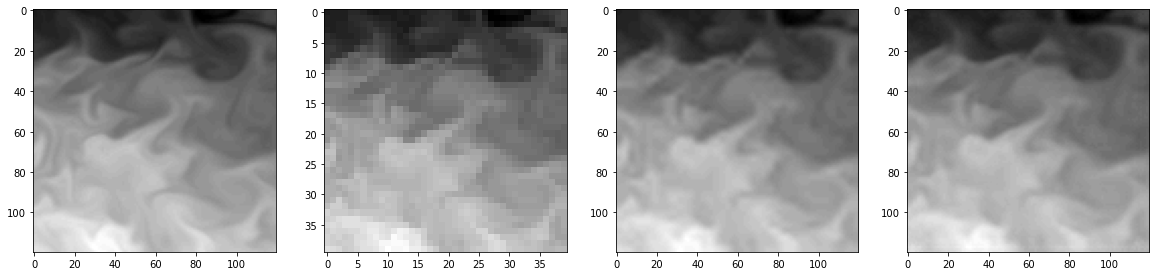

PSNR(HR, Interpolation) = 37.83665579361426
PSNR(HR, Prediction) = 43.3961366646253


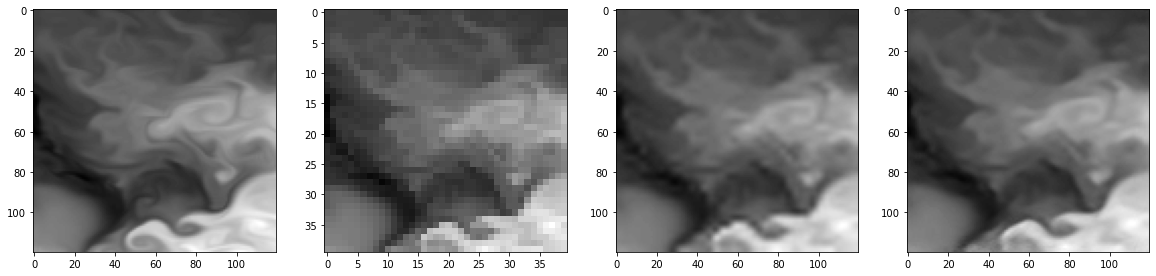

PSNR(HR, Interpolation) = 41.13314878946919
PSNR(HR, Prediction) = 44.057248699807516


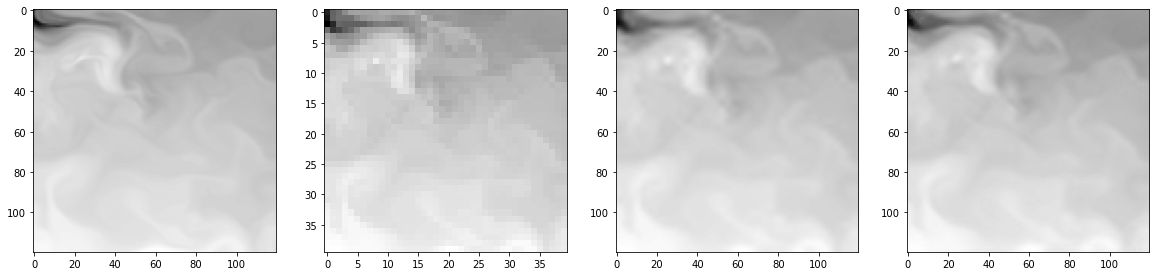

PSNR(HR, Interpolation) = 42.231927883192704
PSNR(HR, Prediction) = 47.035908716475554


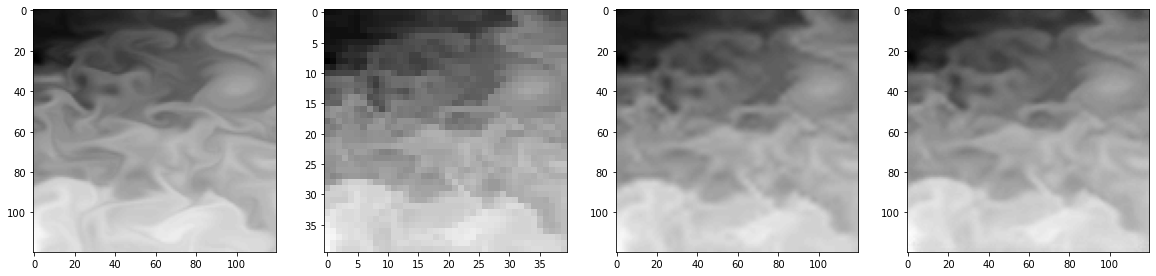

PSNR(HR, Interpolation) = 36.04652068695958
PSNR(HR, Prediction) = 42.024719448247964


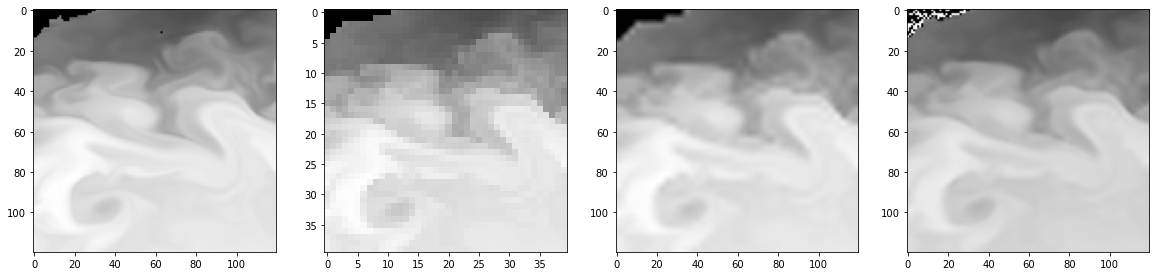

In [5]:
for index in indices:
    hr_img = img_read(imgPaths[index])
    h_orig, w_orig = hr_img.shape
    lr_img = cv2.resize(hr_img, (int(w_orig/SCALE), int(h_orig/SCALE)), interpolation=cv2.INTER_NEAREST)
    bicub = cv2.resize(lr_img, (w_orig, h_orig), interpolation=cv2.INTER_CUBIC)
    
    # bicubic interpolated image in Tensor
    lr_bicub_tensor = transform(bicub)
    lr_bicub_tensor = torch.reshape(lr_bicub_tensor, (1, 1, h_orig, w_orig))
    
    # model inference output
    with torch.no_grad():
        predict = model(lr_bicub_tensor)
    predict = torch.reshape(predict, (1, h_orig, w_orig))
    predict = transforms.ToPILImage()(predict)
    predict = np.array(predict)
    
    # compare PSNR
    print("PSNR(HR, Interpolation) = {}".format(PSNR(hr_img, bicub)))
    print("PSNR(HR, Prediction) = {}".format(PSNR(hr_img, predict)))
    
    # plot results
    plt.figure(figsize=(20,20))
    plt.subplot(1, 4, 1)
    plt.imshow(hr_img, cmap='gray')
    plt.subplot(1, 4, 2)
    plt.imshow(lr_img, cmap='gray')
    plt.subplot(1, 4, 3)
    plt.imshow(bicub, cmap='gray')
    plt.subplot(1, 4, 4)
    plt.imshow(predict, cmap='gray')
    plt.show()